In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

zsh:1: command not found: nvidia-smi
Your runtime has 8.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
# Read the processed dataset.
# semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_features_only', engine='fastparquet')
semg_df = pd.read_parquet('semg_extracted_scalar_features_only/', engine='fastparquet')
semg_df.to_csv('semg_extracted_scalar_features_only.csv')
semg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Columns: 553 entries, subject_id to semg_5_fd_meanfreq_10
dtypes: float64(440), int32(113)
memory usage: 4.5 MB


In [4]:
NO_WINDOWS = 10

non_scalar_features = ['semg_1_fd_fft', 'semg_2_fd_fft', 'semg_3_fd_fft', 'semg_4_fd_fft', 'semg_5_fd_fft',
                      'semg_1_fd_psd', 'semg_2_fd_psd', 'semg_3_fd_psd', 'semg_4_fd_psd', 'semg_5_fd_psd',
                      'semg_1_tfd_stft', 'semg_2_tfd_stft', 'semg_3_tfd_stft', 'semg_4_tfd_stft', 'semg_5_tfd_stft',
                      'semg_1_tfd_mfcc', 'semg_2_tfd_mfcc', 'semg_3_tfd_mfcc', 'semg_4_tfd_mfcc', 'semg_5_tfd_mfcc',
                      'semg_1_tfd_hjorth', 'semg_2_tfd_hjorth', 'semg_3_tfd_hjorth', 'semg_4_tfd_hjorth', 'semg_5_tfd_hjorth',
                      'semg_1_tfd_arcoeffs', 'semg_2_tfd_arcoeffs', 'semg_3_tfd_arcoeffs', 'semg_4_tfd_arcoeffs', 'semg_5_tfd_arcoeffs']

# non_scalar_features = non_scalar_features + [f"{item}_{suffix}" for item in non_scalar_features for suffix in range(1, NO_WINDOWS + 1)]
# print(non_scalar_features)

# scalar_X = semg_df.drop(columns=non_scalar_features)
scalar_X = semg_df
print('scalar_X Columns: ', scalar_X.columns)

# X = semg_df.drop(columns=['activity'])#.astype('float32')
y = semg_df['activity'].astype('int')

# Normalize features
scaler = StandardScaler()
scalar_X = pd.DataFrame(scaler.fit_transform(scalar_X), columns=scalar_X.columns)

y

scalar_X Columns:  Index(['subject_id', 'activity', 'trial_index', 'semg_1_td_mean',
       'semg_1_td_rms', 'semg_1_td_sd', 'semg_1_td_var', 'semg_1_td_iemg',
       'semg_1_td_zcr', 'semg_1_td_ssc',
       ...
       'semg_1_fd_medfreq_10', 'semg_1_fd_meanfreq_10', 'semg_2_fd_medfreq_10',
       'semg_2_fd_meanfreq_10', 'semg_3_fd_medfreq_10',
       'semg_3_fd_meanfreq_10', 'semg_4_fd_medfreq_10',
       'semg_4_fd_meanfreq_10', 'semg_5_fd_medfreq_10',
       'semg_5_fd_meanfreq_10'],
      dtype='object', length=553)


0       20
1       20
2       20
3       20
4       20
        ..
1171    11
1172    11
1173    11
1174    11
1175    11
Name: activity, Length: 1176, dtype: int64

Applying PCA to the Scalar features.

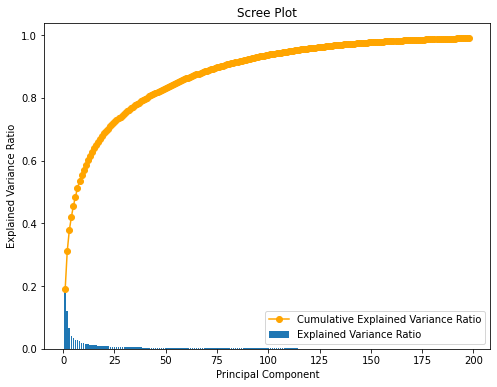

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.99)  # Preserve 99% of the total variance
pca_data = pca.fit_transform(scalar_X)

# Plot the scree plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='orange', label='Cumulative Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets

# Extract the 'activity' column
activity_labels = y

# Get unique activities and assign a color to each
unique_activities = activity_labels.unique()
activity_colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'cyan', 'lime',
                   'gold', 'indigo', 'magenta', 'yellow', 'teal', 'maroon', 'olive', 'navy', 'gray',
                   'black', 'silver', 'crimson']

# Plot the 2D scatter plot with colored data points based on 'activity'
def plot_pca_scatter(selected_activities):
    plt.figure(figsize=(10, 8))
    for i, activity in enumerate(selected_activities):
        mask = (activity_labels == activity)
        plt.scatter(pca_data[mask, 0], pca_data[mask, 1], c=[activity_colors[i]], marker='o', alpha=0.5, label=activity)

    plt.title('2D Scatter Plot of PCA Components')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a multi-select widget to choose activities
activity_chooser = widgets.SelectMultiple(options=unique_activities, description='Choose Activities:')

# Use the interact function to dynamically update the scatter plot based on the selected activities
interact(plot_pca_scatter, selected_activities=activity_chooser)


interactive(children=(SelectMultiple(description='Choose Activities:', options=(20, 16, 9, 17, 6, 18, 7, 19, 1…

<function __main__.plot_pca_scatter(selected_activities)>

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
from ipywidgets import interact, widgets


def plot_pca_3d_scatter(selected_activities):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, activity in enumerate(selected_activities):
        mask = (activity_labels == activity)
        ax.scatter(pca_data[mask, 0], pca_data[mask, 1], pca_data[mask, 2], c=[activity_colors[i]],
                   marker='o', alpha=0.5, label=activity)

    ax.set_title('3D Scatter Plot of PCA Components')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()

    # Set initial view and enable mouse interaction
    ax.view_init(elev=20, azim=30)  # Set the initial view angle
    ax.mouse_init()

    plt.show()

# Create a multi-select widget to choose activities
activity_chooser = widgets.SelectMultiple(options=unique_activities, description='Choose Activities:')

# Use the interact function to dynamically update the scatter plot based on the selected activities
interact(plot_pca_3d_scatter, selected_activities=activity_chooser)


interactive(children=(SelectMultiple(description='Choose Activities:', options=(20, 16, 9, 17, 6, 18, 7, 19, 1…

<function __main__.plot_pca_3d_scatter(selected_activities)>

In [8]:
import plotly.express as px
from ipywidgets import interact, SelectMultiple
from sklearn.decomposition import PCA
import pandas as pd

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=pca_data[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])

# Add activity labels to the PCA DataFrame
pca_df['activity'] = activity_labels

# Get unique activity labels
unique_activities = pca_df['activity'].unique()

# Create a multi-select widget for activity selection
activity_selector = SelectMultiple(options=unique_activities, value=tuple(unique_activities), description='Select Activities')

# Function to update the scatter plot based on selected activities
def update_scatter(selected_activities):
    filtered_df = pca_df[pca_df['activity'].isin(selected_activities)]
    fig = px.scatter_3d(filtered_df, x='PCA1', y='PCA2', z='PCA3', color='activity')
    fig.show()

# Create an interactive 3D scatter plot using Plotly
interact(update_scatter, selected_activities=activity_selector)


interactive(children=(SelectMultiple(description='Select Activities', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…

<function __main__.update_scatter(selected_activities)>

In [9]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# from sklearn.datasets import load_iris

# # Load example data (replace this with your scalar_X and activity_labels)
# data = load_iris()
# scalar_X = data.data
# activity_labels = data.target

# print("TSNE fitting..")

# # Apply t-SNE
# tsne = TSNE(n_components=3, random_state=42)
# tsne_components = tsne.fit_transform(scalar_X)
# print("TSNE fit completed!")


# # Apply UMAP
# print("UMAP fitting..")
# umap_reducer = umap.UMAP(n_components=3, random_state=42)
# umap_components = umap_reducer.fit_transform(scalar_X)
# print("UMAP fit completed!")

# # Create DataFrame with t-SNE components and UMAP components
# tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2', 'TSNE3'])
# umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# # Add activity labels to the components DataFrames
# tsne_df['activity'] = activity_labels
# umap_df['activity'] = activity_labels

# print("Plotting data now..")

# # Create 3D scatter plot using Matplotlib
# def plot_3d_scatter(data_df, title):
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Define a color map for different activities
#     cmap = plt.get_cmap('tab20')
    
#     # Scatter plot for each activity
#     for i, activity in enumerate(data_df['activity'].unique()):
#         activity_data = data_df[data_df['activity'] == activity]
#         ax.scatter(
#             activity_data['TSNE1'], activity_data['TSNE2'], activity_data['TSNE3'],
#             c=[cmap(i)],
#             label=f'Activity {activity}'
#         )
    
#     ax.set_title(title)
#     ax.set_xlabel('TSNE1')
#     ax.set_ylabel('TSNE2')
#     ax.set_zlabel('TSNE3')
#     ax.legend()
#     plt.show()

# # Plot t-SNE 3D scatter plot
# plot_3d_scatter(tsne_df, title='t-SNE 3D Scatter Plot')

# # Plot UMAP 3D scatter plot
# plot_3d_scatter(umap_df, title='UMAP 3D Scatter Plot')

In [10]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# from sklearn.metrics import silhouette_score

# # Drop the non-feature columns
# feature_cols = semg_df.columns
# df_features = semg_df.drop(columns=['subject_id', 'activity', 'trial_index'])

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_features)

# # K-means Clustering
# n_clusters = 21
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# kmeans_labels = kmeans.fit_predict(df_scaled)

# # Evaluate K-means Clustering
# silhouette_avg_kmeans = silhouette_score(df_scaled, kmeans_labels)
# print(f"K-means silhouette score: {silhouette_avg_kmeans}")

# # Agglomerative Clustering
# agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
# agg_labels = agg_clustering.fit_predict(df_scaled)

# # Evaluate Agglomerative Clustering
# silhouette_avg_agg = silhouette_score(df_scaled, agg_labels)
# print(f"Agglomerative silhouette score: {silhouette_avg_agg}")

# # DBSCAN Clustering
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan_labels = dbscan.fit_predict(df_scaled)

# # Filter out noise points for DBSCAN silhouette score
# dbscan_core_samples_mask = np.zeros_like(dbscan_labels, dtype=bool)
# dbscan_core_samples_mask[dbscan_labels != -1] = True
# if len(set(dbscan_labels)) > 1:  # more than 1 cluster and noise
#     silhouette_avg_dbscan = silhouette_score(df_scaled[dbscan_core_samples_mask], dbscan_labels[dbscan_core_samples_mask])
#     print(f"DBSCAN silhouette score: {silhouette_avg_dbscan}")

# # Plotting clusters
# semg_df['kmeans_labels'] = kmeans_labels
# semg_df['agg_labels'] = agg_labels
# semg_df['dbscan_labels'] = dbscan_labels

# sns.pairplot(semg_df, hue='activity', vars=feature_cols, palette='Dark2', plot_kws={'alpha': 0.5})
# plt.title("Original Activities")
# plt.show()

# sns.pairplot(semg_df, hue='kmeans_labels', vars=feature_cols, palette='Dark2', plot_kws={'alpha': 0.5})
# plt.title("K-means Clusters")
# plt.show()

# sns.pairplot(semg_df, hue='agg_labels', vars=feature_cols, palette='Dark2', plot_kws={'alpha': 0.5})
# plt.title("Agglomerative Clusters")
# plt.show()

# sns.pairplot(semg_df, hue='dbscan_labels', vars=feature_cols, palette='Dark2', plot_kws={'alpha': 0.5})
# plt.title("DBSCAN Clusters")
# plt.show()


/Users/sauravdas221/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



K-means silhouette score: 0.25868356135117376
Agglomerative silhouette score: 0.23676928242145362


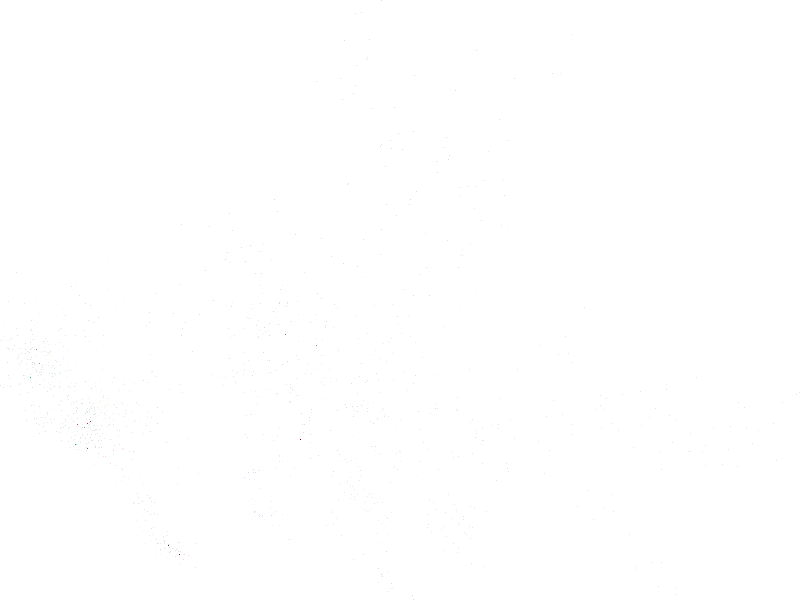

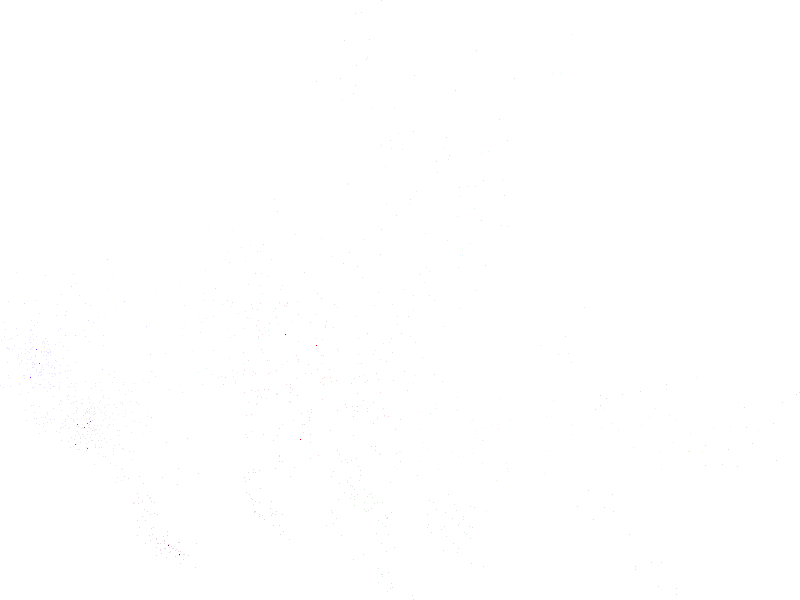

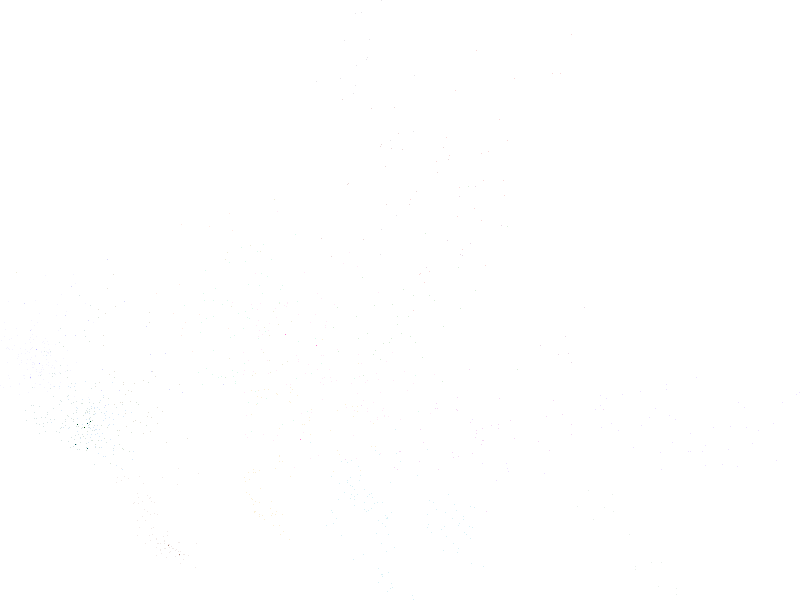

In [11]:
!pip install datashader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import datashader as ds
import datashader.transfer_functions as tf

from colorcet import palette
from IPython.display import display

# Assuming you have a DataFrame named semg_df
feature_cols = semg_df.columns[4:]
df_features = semg_df[feature_cols]

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Dimensionality reduction using PCA
pca = PCA(n_components=10)
df_scaled_pca = pca.fit_transform(df_scaled)

# Number of clusters
n_clusters = 21

# K-means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(df_scaled_pca)
silhouette_avg_kmeans = silhouette_score(df_scaled_pca, kmeans_labels)
print(f"K-means silhouette score: {silhouette_avg_kmeans}")

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(df_scaled_pca)
silhouette_avg_agg = silhouette_score(df_scaled_pca, agg_labels)
print(f"Agglomerative silhouette score: {silhouette_avg_agg}")

# Adding cluster labels back to the DataFrame
semg_df['kmeans_labels'] = kmeans_labels
semg_df['agg_labels'] = agg_labels


def datashader_plot(df, col, title):
    canvas = ds.Canvas(x_range=(df['PCA1'].min(), df['PCA1'].max()), 
                       y_range=(df['PCA2'].min(), df['PCA2'].max()), 
                       plot_width=800, plot_height=600)
    
    agg = canvas.points(df, 'PCA1', 'PCA2', ds.count_cat(col))
    
    # Get the number of unique categories
    n_cats = len(df[col].cat.categories)
    
    # Generate a palette with n_cats unique colors
    color_key = palette['glasbey_dark'][0:n_cats]
    
    img = ds.transfer_functions.shade(agg, color_key=color_key, how='eq_hist')
    ds.utils.export_image(img=img, filename=title, background="black")
    display(img)  # Display the image

# Reduce dimensions to 2 for Datashader plotting
pca_2d = PCA(n_components=2)
df_2d = pd.DataFrame(pca_2d.fit_transform(df_scaled), columns=['PCA1', 'PCA2'])
df_2d['activity'] = pd.Series(semg_df['activity']).astype('category')
df_2d['kmeans_labels'] = pd.Series(kmeans_labels).astype('category')
df_2d['agg_labels'] = pd.Series(agg_labels).astype('category')

# Plot using Datashader
datashader_plot(df_2d, 'activity', "Original Activities")
datashader_plot(df_2d, 'kmeans_labels', "K-means Clusters")
datashader_plot(df_2d, 'agg_labels', "Agglomerative Clusters")
